# Portfolio Optimization for [CQA Trading Competition](http://www.cqa.org/investment_challenge)

#### Sarah Graney

CBE 40455: Final Project  
December 14, 2017

## Introduction

#### Before running this program - run "Final Project - Data Import" to pull price data from Yahoo Finance
#### Also require the excel file "Beta.xls" to pull betas for calculations

This script takes an input of stocks chosen through fundamental analysis by the competition team and outputs a weighting based that minimizes portfolio variance while keeping within competition guidelines 

Guidelines include:
1. Manage a long/short equity portfolio from November 10, 2017 through through March 30, 2018
2. Must manage 1,000,000 dollars of capital for a total of 2,000,000 in a long/short portfolio  
3. Must be market neutral (Beta < +/-0.25)
4. Must be fully invested with no less than 5% cash
5. No position can be more than 5% of the portfolio (50,000 dollars)
6. Must choose positions from a provided universe of ~1000 large and mid-cap stocks. Investment in ETFs is prohibited

Then there was also an added constraint to be neutral across sectors as well at the request of the competition team mentor. 

Note that betas were provided by the competition for the universe of stocks, and they did not specify what this beta was in relation to or over what time period. So rather than calculating a beta, the ones provided will be assumed constant for the duration of the competition.

Outputs to this script are an excel file providing: 
1. Average return of each position
2. Correlation data
3. Beta for each sector and the overall portfolio
4. Recommended weighting and number of shares to purchase or short

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

# data wrangling libraries
import pandas_datareader.data as web
import pandas as pd
import datetime

%matplotlib inline

In [2]:
#Price Data Import
short = ['CTL', 'GE', 'T', 'USM', 'AL', 'EWBC', 'MNST', 'LULU', 'ALK', 'CVS', 'GILD', 'PYPL', 
         'DRI', 'DPS', 'PG', 'EFX', 'EXPE', 'AZO']
long = ['PCLN', 'AMZN', 'CHTR', 'NFLX', 'LRCX', 'GD', 'BRK-B', 'CME', 'PM', 'CASY', 'ABBV', 
        'DHR', 'MDT', 'HCA', 'XPO', 'MU', 'SQ', 'FL', 'BHGE', 'COG', 'DISCK']
index = ['^GSPC','^RUT']
pos = long+short

Beta_all = pd.read_excel("Beta.xls", index_col=0, header=0)
Sector = pd.read_excel("Industries.xlsx", index_col=0, header=0)

Prices = pd.read_pickle("Price_Data1y", compression='infer')
PricesSim = pd.read_pickle("Price_Data2y", compression='infer')

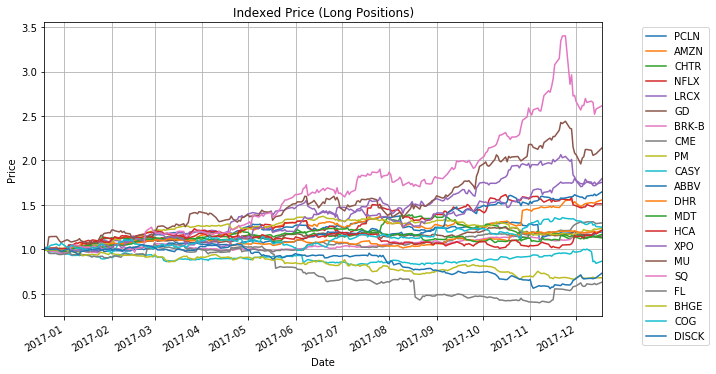

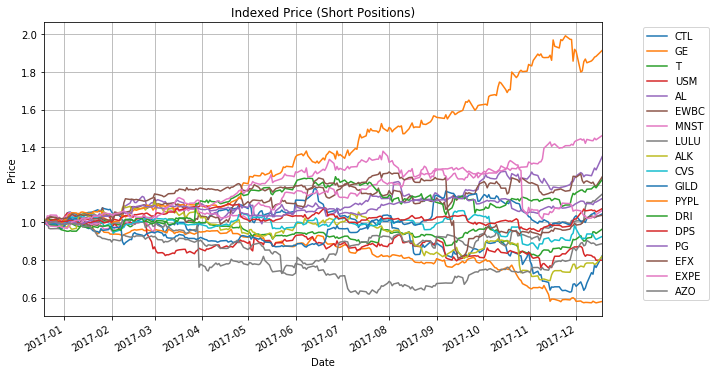

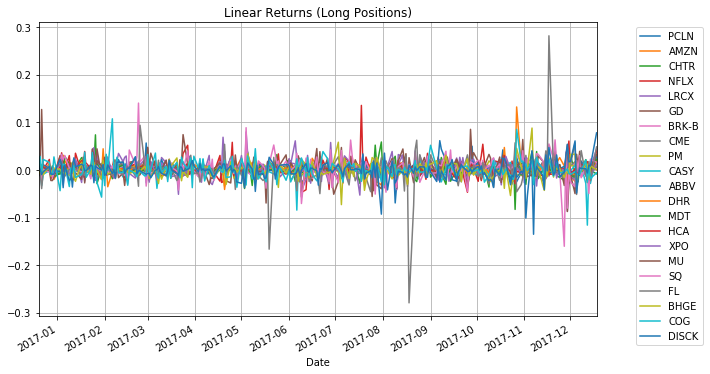

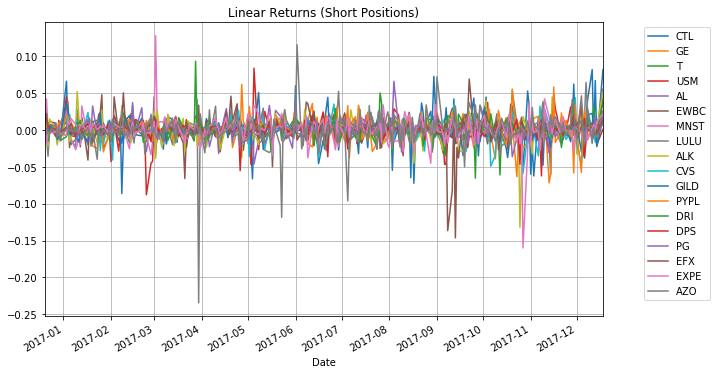

In [3]:
#Plot relative price and returns

RelPrice = pd.DataFrame()
i = len(Prices)
for p in pos:
    RelPrice[p] = Prices[p]/Prices[p][0]

Beta = pd.DataFrame()
for p in pos:
    Beta[p] = Beta_all.loc[p]
Beta = Beta.T
    
Returns = Prices.diff()/Prices.shift(1)
Returns.dropna(inplace=True)

RPLong = pd.DataFrame()
RPShort = pd.DataFrame()
RLong = pd.DataFrame()
RShort = pd.DataFrame()

for l in long:
    RPLong[l] = RelPrice[l]
    RLong[l] = Returns[l]
for s in short:
    RPShort[s] = RelPrice[s]
    RShort[s] = Returns[s]

RPLong.plot(figsize=(10,6))

plt.title('Indexed Price (Long Positions)')
plt.ylabel('Price')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.grid()

RPShort.plot(figsize=(10,6))

plt.title('Indexed Price (Short Positions)')
plt.ylabel('Price')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.grid()



RLong.plot(figsize=(10,6))
plt.title('Linear Returns (Long Positions)')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.grid()

RShort.plot(figsize=(10,6))
plt.title('Linear Returns (Short Positions)')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.grid()

In [4]:
rlin = Returns.mean()
stdev = Returns.std()

rlog = np.log(Prices).diff().mean()
Rpd = pd.DataFrame(data=[rlin,rlog], index=["Lin Return","Log Return"])
Rpd = Rpd.T
Rpd.to_excel("Analysis_Output.xlsx",sheet_name="Returns")

In [5]:
#Determin Correlation between positions
sigma = Returns.cov()
rho = sigma.copy()

for i in Returns.columns.values.tolist():
    for j in Returns.columns.values.tolist():
        rho[i][j] = sigma[i][j]/stdev[i]/stdev[j]

sigmaL = RLong.cov()
rhoL = sigmaL.copy()

for i in RLong.columns.values.tolist():
    for j in RLong.columns.values.tolist():
        rhoL[i][j] = sigmaL[i][j]/stdev[i]/stdev[j]

sigmaS = RShort.cov()
rhoS = sigmaS.copy()

for i in RShort.columns.values.tolist():
    for j in RShort.columns.values.tolist():
        rhoS[i][j] = sigmaS[i][j]/stdev[i]/stdev[j]

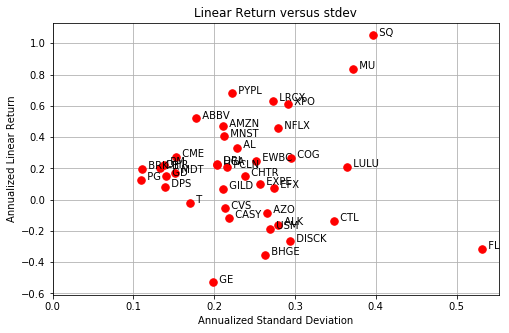

In [6]:
plt.figure(figsize=(8,5))
for s in Returns.columns.values.tolist():
    plt.plot(np.sqrt(252.0)*stdev[s],252*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252*rlin[s],"  {0:5<s}".format(s))

plt.xlim(0.0,plt.xlim()[1])
plt.title('Linear Return versus stdev')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Linear Return')
plt.grid()

In [7]:
from pyomo.environ import *

NL = len(RLong.columns.values.tolist())
NS = len(RShort.columns.values.tolist())
NT = NL + NS

m = ConcreteModel()
m.w = Var(range(0,NT),domain=Reals)

s = np.array(sigma)

#Objective to minimize portfolio variance
m.OBJ = Objective(expr = sum(m.w[i]*s[i][j]*m.w[j] for i in range(0,NT) for j in range(0,NT))
                  ,sense=minimize)

m.cons = ConstraintList()

#Max position size constraints
for i in range(0,NT):
    if i<NL:
        m.cons.add(m.w[i] <= 0.05)
        m.cons.add(m.w[i] >= 0.001)
    if i>=NL:
        m.cons.add(m.w[i] <= -0.001)
        m.cons.add(m.w[i] >=-0.05)

#Market neutral constraints
m.cons.add(sum(Beta.loc[pos[i]]["Beta"]*m.w[i] for i in range(0,NT))<=0.2)
m.cons.add(sum(Beta.loc[pos[i]]["Beta"]*m.w[i] for i in range(0,NT))>=-0.2)
#Full investment constraints
m.cons.add(sum(m.w[i] for i in range(0,NL))>=0.95)
#Industry neutral constraints
for s in Sector:
    m.cons.add(abs(sum(m.w[i]*Beta.loc[pos[i]]["Beta"]*Sector[s][pos[i]] for i in range(0,NT)))<=0.15)

SolverFactory('ipopt').solve(m)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 89, 'Number of variables': 39, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.8\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.13443613052368164}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

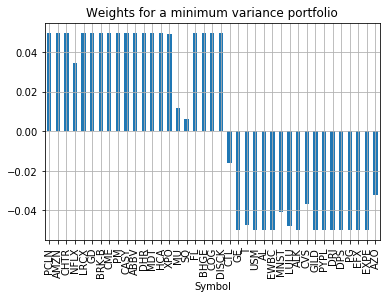

In [8]:
wval = pd.Series([m.w[i]() for i in range(0,NT)],Returns.columns)
wval.plot(kind='bar')

plt.xlabel('Symbol')
plt.title('Weights for a minimum variance portfolio')
plt.grid()

S = Sector.columns.values.tolist()
S.append('Overall Portfolio')
P_beta = np.zeros(len(S))
j = 0
for s in Sector:
    P_beta[j] = sum(wval[i]*Beta.loc[i]["Beta"]*Sector[s][i] for i in pos)
    j = j+1
P_beta[j] = sum(wval[i]*Beta.loc[i]["Beta"] for i in pos)
Portfolio_beta = pd.DataFrame(data=P_beta,index=S, columns=['Industry Beta'])

In [9]:
L = len(Prices)-1
CP = pd.Series([Prices[p][L] for p in pos],Returns.columns)
Port_Size = 1000000
Shares = pd.Series([np.round(wval[p]*Port_Size/Prices[p][L]) for p in pos],Returns.columns)
Portfolio = pd.DataFrame(data=[wval,CP,Shares], index=['Weight','Share Price','Shares'])
Portfolio = Portfolio.T

In [10]:
#Adding Data to an excel
writer = pd.ExcelWriter('Analysis_Output.xlsx', engine='xlsxwriter')
rho.to_excel(writer,"All_Correlations")
rhoL.to_excel(writer,"Long_Correlations")
rhoS.to_excel(writer,"Short_Correlations")
Rpd.to_excel(writer,"Returns")
Portfolio.to_excel(writer,"Portfolio")
Portfolio_beta.to_excel(writer,"Betas")
writer.save()